# Is the accuracy of sex prediction improved comparing specific regions of the Bluegill?

### Loading and processing the data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import os
from PIL import Image
# Folder where all images are located
mydir = 'data'

#### Here we create labels, differeniating between sex and region as so:
Female Region 1: **0**, Female Region 2: **1**

Male Region 1: **2**, Male Region 2: **3**

In [3]:
# loading the data into files
labels = np.array([])

i=0
for file in os.listdir(mydir):
    if file.endswith(".JPG"): # Will only read .jpg files (you can change this to other formats)
        filename = mydir+'/'+file
        # Loads image, converts to grayscale and resizes it to a 600x600 image
        y = np.array(Image.open(filename).convert('RGB').convert('L').resize((600,600)))
        
        # Resizes 300x300 image to 90,000x1 array
        col_y = y.ravel()[:,np.newaxis]
        
        # Saves
        if i==0:
            data = col_y
        else:
            data = np.hstack((data, col_y))
        
        # Creates labels from filename
        if i < 10: # Female_1_R1 (0)
            labels = np.hstack((labels, int(0))) # this assumes the file extension has 3 letters (such as jpg)
        elif 10 <= i < 20: # Female_1_R2
            labels = np.hstack((labels, int(1)))
        elif 20 <= i < 30: # Female 2 R1
            labels = np.hstack((labels, int(0))) # this assumes the file extension has 3 letters (such as jpg)
        elif 30 <= i < 40: # Female 2 R2
            labels = np.hstack((labels, int(1)))
        elif 40 <= i < 50: # Male_1_R1
            labels = np.hstack((labels, int(2)))
        elif 50 <= i < 60: # Male 1 R2
            labels = np.hstack((labels, int(3))) # this assumes the file extension has 3 letters (such as jpg)
        elif 60 <= i < 70: # Male 2 R1
            labels = np.hstack((labels, int(2)))
        else:                     # Male 2 R2
            labels = np.hstack((labels, int(3)))
        i+=1

print('-------------------------------------------------------')
print('----------------------DONE-----------------------------')
print('-------------------------------------------------------')
print('There are ', data.shape[1],' images')
print('There are ', labels.shape[0],' labels')

# Saves the files to your current directory
np.save('data', data)
np.save('labels', labels)

-------------------------------------------------------
----------------------DONE-----------------------------
-------------------------------------------------------
There are  80  images
There are  80  labels


In [4]:
# Normalization of the data
# Function to normalize data by dividing each pixel value by 255
def normalize(data):
    return (data.astype(float)/255)

In [5]:
data_normalized = normalize(data)
print(data_normalized.shape)

(360000, 80)


#### Dividing Normalized data into regions before forming a training and test set

In [6]:
data1 = (data_normalized.T)

In [7]:
# Creating empty matrixes to store the data
data_R1 = np.zeros((40,360000))
data_R2 = np.zeros((40,360000))
labels_R1 = np.zeros(40)
labels_R2 = np.zeros(40)

In [8]:
i=0
j=i-10
k=i-20
m=i-30
n=i-40
for num in range(80):
    if i < 10: # Female_1_R1 (0)
        data_R1[i,:] = data1[i,:]
        labels_R1[i] = labels[i]
    elif 10 <= i < 20: # Female_1_R2
        data_R2[j,:] = data1[i,:]
        labels_R2[j] = labels[i]
    elif 20 <= i < 30: # Female 2 R1
        data_R1[j,:] = data1[i,:]
        labels_R1[j] = labels[i]
    elif 30 <= i < 40: # Female 2 R2
        data_R2[k,:] = data1[i,:]
        labels_R2[k] = labels[i]
    elif 40 <= i < 50: # Male_1_R1
        data_R1[k,:] = data1[i,:]
        labels_R1[k] = labels[i]
    elif 50 <= i < 60: # Male 1 R2
        data_R2[m,:] = data1[i,:]
        labels_R2[m] = labels[i]
    elif 60 <= i < 70: # Male 2 R1
        data_R1[m,:] = data1[i,:]
        labels_R1[m] = labels[i]
    elif 70 <= i < 80:                     # Male 2 R2
        data_R2[n,:] = data1[i,:]
        labels_R2[n] = labels[i]
    i+=1
    j+=1
    k+=1
    m+=1
    n+=1

### Testing Sexing Accuracy of Main body region (R1) vs. Caudal Region (R2)

In [9]:
# Preparing SVC and PCA
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score

### Test 1: Comparing Region 1

In [34]:
# Breaking the data into a training a test set
Xtrain, Xtest, ytrain, ytest = train_test_split(data_R1, labels_R1,
                                                random_state=42)

NOTE: Number of PCA components were determined on the larger test by iterating through several combinations

In [36]:
# Creating the model
pca = RandomizedPCA(n_components=8, whiten=True, svd_solver='full', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)
# Determining the best coefficents
param_grid = {'svc__C': [5],
              'svc__gamma': [0.005]}
grid = GridSearchCV(model, param_grid)

In [37]:
# param_grid = {'svc__C': [0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.25, 1.5, 3, 5, 10, 50],
#               'svc__gamma': [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}
# Old best: 10, 0.05

In [38]:
# Testing & Testing the Model
grid.fit(Xtrain, ytrain)
print(grid.best_params_)
model = grid.best_estimator_
yfit = model.predict(Xtest)

{'svc__C': 5, 'svc__gamma': 0.005}


#### METRICS:

In [39]:
r2_score(ytest, yfit)

0.16666666666666674

In [60]:
ytest

array([0., 0., 0., 2., 0., 0., 2., 2., 2., 0.])

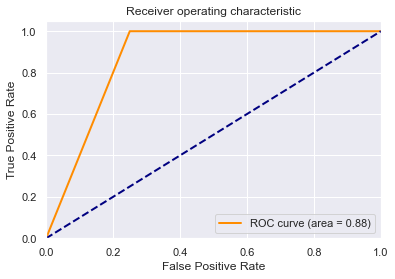

In [67]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(yfit, ytest, pos_label=2)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
print(classification_report(y_true=ytest, y_pred=yfit))

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         6
         2.0       1.00      0.50      0.67         4

    accuracy                           0.80        10
   macro avg       0.88      0.75      0.76        10
weighted avg       0.85      0.80      0.78        10



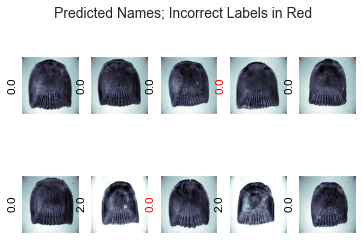

In [16]:
fig, ax = plt.subplots(2, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i,:].reshape(600,600), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(yfit[i],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

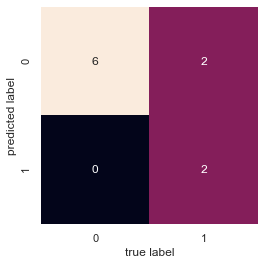

In [17]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Test 2: Comparing Region 2

In [10]:
# Breaking the data into a training a test set
Xtrain, Xtest, ytrain, ytest = train_test_split(data_R2, labels_R2,
                                                random_state=42)

In [11]:
# Creating the model
pca = RandomizedPCA(n_components=8, whiten=True, svd_solver='full', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)
# Determining the best coefficents
param_grid = {'svc__C': [0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.25, 1.5, 3, 5, 10, 50],
              'svc__gamma': [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}
grid = GridSearchCV(model, param_grid)

In [12]:
# Testing & Testing the Model
grid.fit(Xtrain, ytrain)
print(grid.best_params_)
model = grid.best_estimator_
yfit = model.predict(Xtest)

{'svc__C': 0.5, 'svc__gamma': 0.05}


In [17]:
ytest,yfit

(array([1., 1., 1., 3., 1., 1., 3., 3., 3., 1.]),
 array([1., 1., 1., 3., 1., 1., 3., 3., 3., 1.]))

#### METRICS:

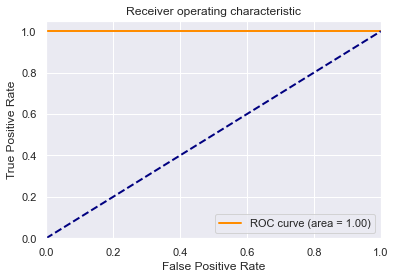

In [18]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(yfit, ytest, pos_label=3)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [21]:
print(classification_report(y_true=ytest, y_pred=yfit))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         6
         3.0       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



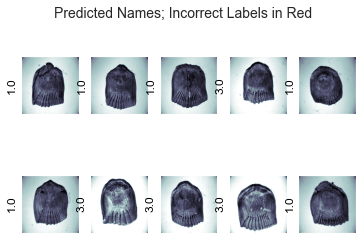

In [22]:
fig, ax = plt.subplots(2, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i,:].reshape(600,600), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(yfit[i],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

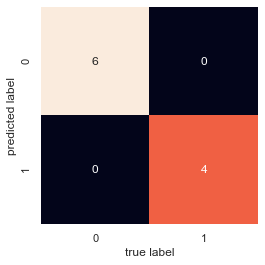

In [24]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');